## Imports

In [1]:
import os

import pyrootutils

root = pyrootutils.setup_root(
    search_from=os.path.dirname(os.getcwd()),
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)

if os.getenv("DATA_ROOT") is None:
    os.environ["DATA_ROOT"] = f"{root}"

In [2]:
from pathlib import Path
import cv2
import hydra
from hydra import compose, initialize
import supervision as sv

In [3]:
import torch

# Setup device-agnostic code
if torch.cuda.is_available():
    DEVICE = "cuda"  # NVIDIA GPU
    print("GPU Found!!")
else:
    raise Exception("No GPU Found!!")

GPU Found!!


## Paths setup

In [4]:
from omegaconf import DictConfig

with initialize(config_path="../configs", job_name="EDA", version_base=None):
    cfg: DictConfig = compose(config_name="train.yaml")
    # print(OmegaConf.to_yaml(cfg))
    print(cfg.paths)

{'root_dir': '${oc.env:PROJECT_ROOT}', 'root_data_dir': '${oc.env:DATA_ROOT}', 'results_dir': '${paths.root_dir}/results', 'log_dir': '${paths.root_dir}/logs/', 'output_dir': '${hydra:runtime.output_dir}', 'work_dir': '${hydra:runtime.cwd}'}


In [5]:
# auto reload libs
%load_ext autoreload
%autoreload 2

## Download Datasets

In [6]:
ROOT_DIR = Path(cfg.paths.root_dir)
ROOT_DATA_DIR = Path(cfg.paths.root_data_dir)
DATA_DIR = ROOT_DATA_DIR / cfg.datasets.datasets_dir
DATASET  = cfg.datasets.roboflow
DATA_DIR.mkdir(parents=True, exist_ok=True)
DATASET_DIR = DATA_DIR/ cfg.datasets.dataset_name
CLASS_NAMES = cfg.datasets.names

In [7]:
if len(list(DATA_DIR.iterdir())) == 0:
    from roboflow import Roboflow

    rf = Roboflow()
    project = rf.workspace(DATASET.workspace).project(DATASET.project)
    version = project.version(DATASET.version)
    dataset = version.download(model_format=DATASET.model)

## Data Visualization

In [8]:
TRAIN_IMAGES_DIR = DATASET_DIR / "train" / "images"
TRAIN_LABELS_DIR = DATASET_DIR / "train"  / "labels"

VALID_IMAGES_DIR = DATASET_DIR / "valid" / "images"
VALID_LABELS_DIR = DATASET_DIR / "valid"  / "labels"

TEST_IMAGES_DIR = DATASET_DIR / "test" / "images"
TEST_LABELS_DIR = DATASET_DIR / "test"  / "labels"

In [9]:
VALID_IMAGES_DIR

PosixPath('/workspaces/football-players-tracking-yolo/data/football-players-detection-14/valid/images')

In [10]:
ds_train = sv.DetectionDataset.from_yolo(
    images_directory_path=f'{TRAIN_IMAGES_DIR}',
    annotations_directory_path=f'{TRAIN_LABELS_DIR}',
    data_yaml_path=str(DATASET_DIR/'data.yaml')
)
ds_train

In [11]:
ds_valid = sv.DetectionDataset.from_yolo(
    images_directory_path=f'{VALID_IMAGES_DIR}',
    annotations_directory_path=f'{VALID_LABELS_DIR}',
    data_yaml_path=str(DATASET_DIR/'data.yaml')
)

ds_test = sv.DetectionDataset.from_yolo(
    images_directory_path=f'{TEST_IMAGES_DIR}',
    annotations_directory_path=f'{TEST_LABELS_DIR}',
    data_yaml_path=str(DATASET_DIR/'data.yaml')
)

In [12]:
ds_train.classes

['ball', 'goalkeeper', 'player', 'referee']

In [13]:
len(ds_train), len(ds_valid), len(ds_test)

(298, 49, 25)

In [14]:
ds = sv.DetectionDataset.merge([ds_train, ds_valid, ds_test])

len(ds)

372

In [15]:
box_annot = sv.BoxAnnotator()
label_annot= sv.LabelAnnotator()

In [16]:
annotated_images = []
for i in range(16):
    _, image, annotations = ds[i]

    labels = [ds.classes[class_id] for class_id in annotations.class_id]

    annotated_image = image.copy()
    annotated_image = box_annot.annotate(annotated_image, annotations)
    annotated_image = label_annot.annotate(annotated_image, annotations, labels)
    annotated_images.append(annotated_image)

In [ ]:
grid = sv.create_tiles(
    annotated_images,
    grid_size=(4, 4),
    single_tile_size=(400, 400),
    tile_padding_color=sv.Color.WHITE,
    tile_margin_color=sv.Color.WHITE
)

array([[[ 23,  34,  32],
        [ 17,  26,  25],
        [ 17,  26,  26],
        ...,
        [ 81, 135, 121],
        [ 64, 120, 105],
        [ 64, 122, 107]],

       [[ 35,  48,  46],
        [ 28,  39,  37],
        [ 42,  52,  51],
        ...,
        [ 80, 135, 118],
        [ 66, 122, 105],
        [ 67, 125, 107]],

       [[ 37,  50,  49],
        [ 15,  28,  27],
        [ 28,  40,  40],
        ...,
        [ 81, 136, 118],
        [ 72, 128, 110],
        [ 74, 132, 113]],

       ...,

       [[ 42, 102,  72],
        [ 41, 101,  71],
        [ 41, 101,  71],
        ...,
        [ 15,  93, 115],
        [ 13,  92, 114],
        [ 15,  94, 116]],

       [[ 42, 102,  72],
        [ 41, 101,  71],
        [ 41, 101,  71],
        ...,
        [ 16,  93, 120],
        [ 13,  90, 116],
        [ 17,  95, 119]],

       [[ 42, 101,  71],
        [ 41, 101,  71],
        [ 41, 101,  71],
        ...,
        [ 15,  93, 122],
        [ 11,  90, 118],
        [ 16,  95, 122]]

(np.float64(-0.5), np.float64(1629.5), np.float64(1629.5), np.float64(-0.5))

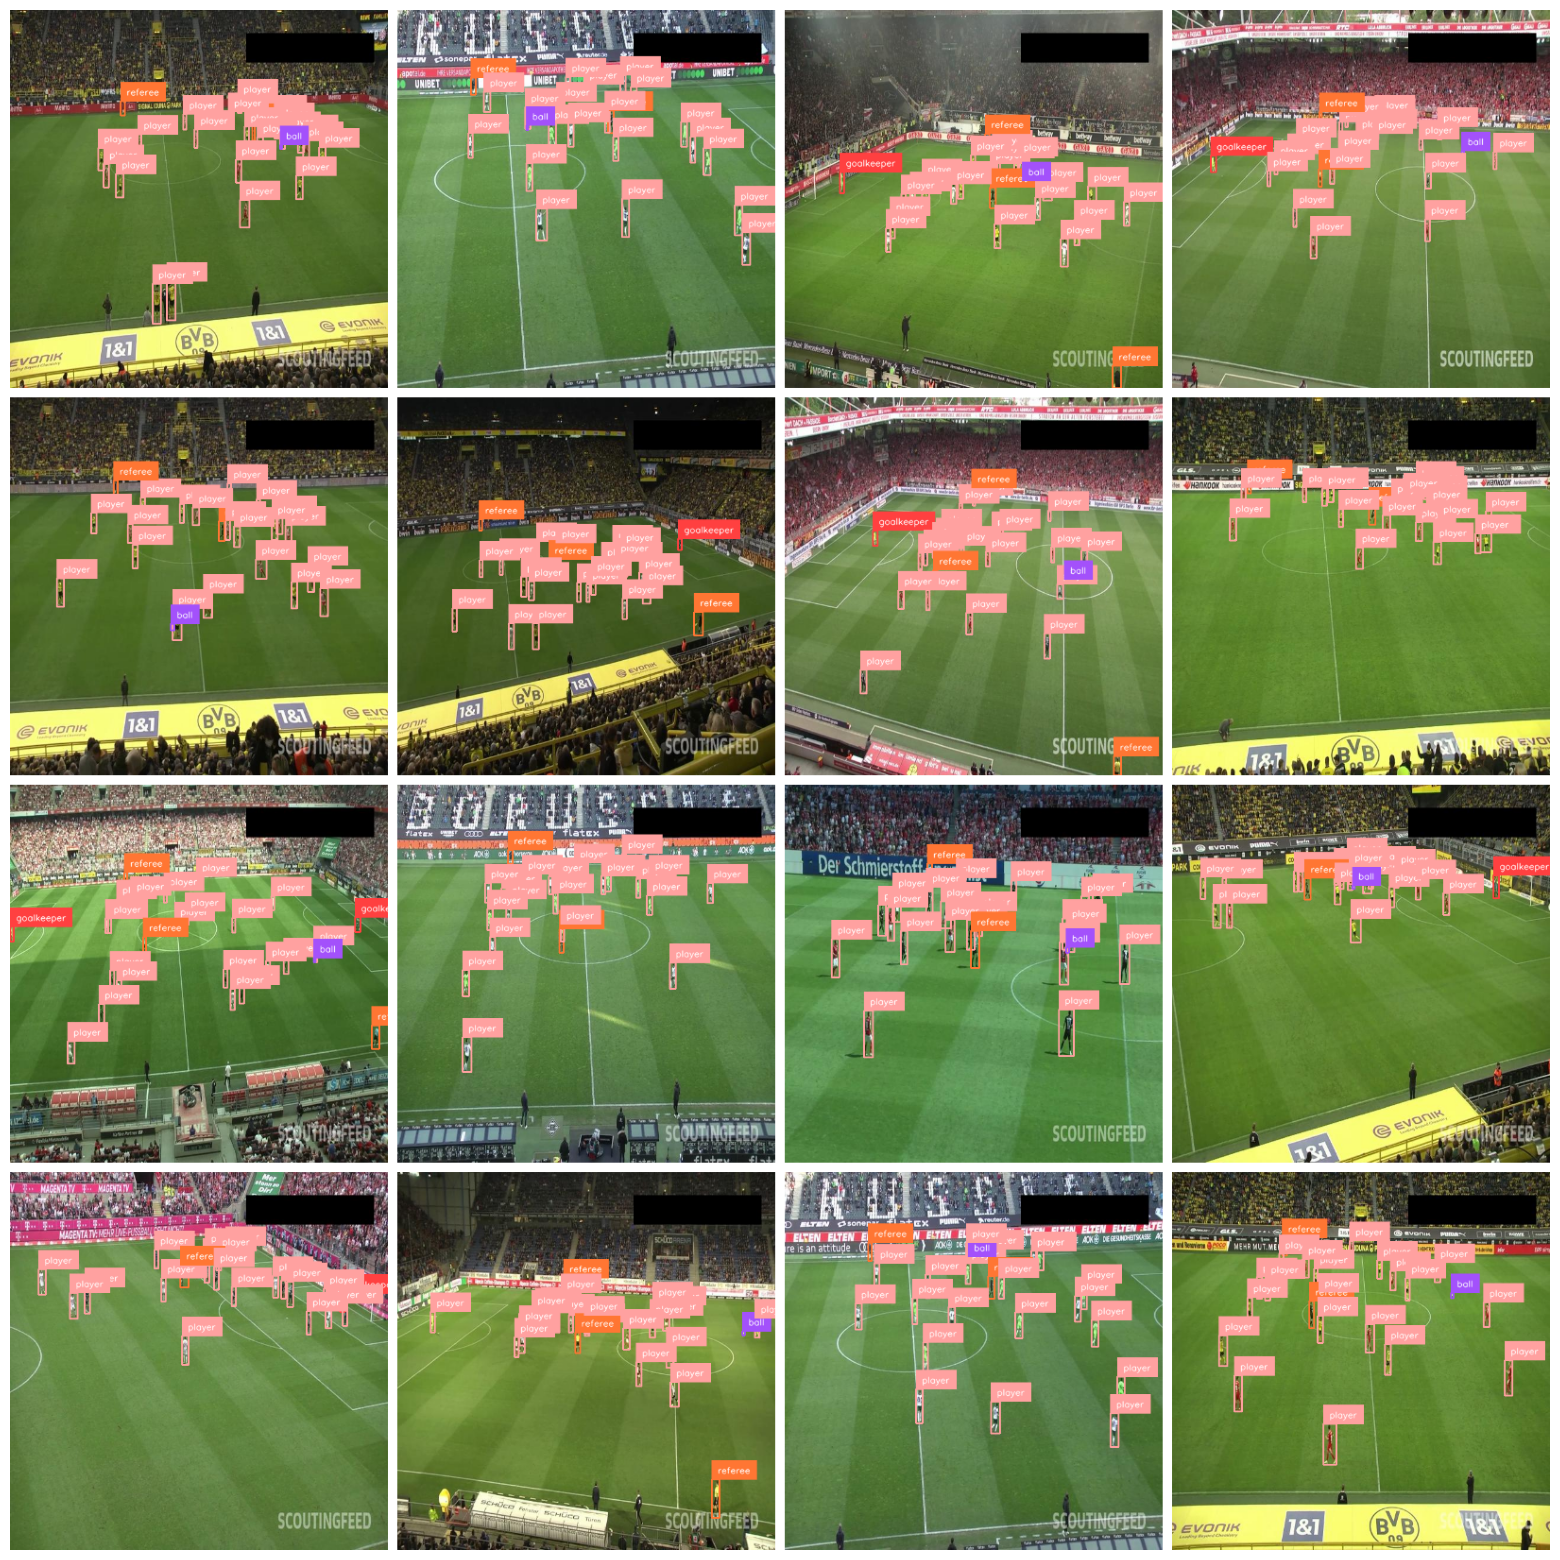

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
rgb_grid = cv2.cvtColor(grid, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_grid)
plt.grid(False)
plt.axis("off")